In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display
import pickle
import sklearn.metrics as metrics
from tabulate import tabulate
import torch

In [2]:
import sys
import os

# Add the 'project' directory to the path
sys.path.append(os.path.abspath('..'))

from project_code.algorithms.taxonomic_1nn import TaxonomicLabelEncoder
from project_code.data.load_data import load_col_types, load_data
from project_code.data.prepare_data_sklearn import get_features_targets, get_single_output_col_types
from project_code.utils.results import get_best_model_file, fetch_best_results_per_model
from project_code.evaluate.score import mean_deb_loss
from project_code.evaluate.prediction_error import compute_parameter_mape
from project_code.inference.parameters import get_core_parameter_predictions, convert_output_to_parameter_predictions, \
    PARAMETER_COLS

# Loading data and models

In [3]:
datasets_folder = f'../data/processed/'

dataset_of_model = {
    'MultiTaskElasticNet': 'ratio_output_no_pub_age_taxonomy_ecocodes',
    'RandomForestRegressor': 'ratio_output_no_pub_age_taxonomy_ecocodes',
    'TaxonomicKNNRegressor': 'biologist_no_pub_age',  
    'MLP': 'all_constraints_no_pub_age_taxonomy_ecocodes',
    'DEBNetHC': 'all_constraints_no_pub_age_taxonomy_ecocodes',
    #'DEBNetHCSoftplus': 'all_constraints_no_pub_age_taxonomy_ecocodes',
    'DEBNetSC': 'all_constraints_no_pub_age_taxonomy_ecocodes',
    #'DEBNet': 'all_constraints_no_pub_age_taxonomy_ecocodes',
}


## Loading best models

In [4]:
def load_model(model_file):
    if model_file[-4:] == '.pkl':
        with open(f"{results_folder}/models/{model_file}", 'rb') as f:
            model = pickle.load(f)
    elif model_file[-4:] == '.pth':
        model = torch.load(f"{results_folder}/models/{model_file}")
        model.eval()
    return model

In [5]:
best_models = {}
for mt in dataset_of_model.keys():  
    results_folder = f'../results/{dataset_of_model[mt]}/all'
    if mt in ['MLP']:
        metric = 'GEF'
    else:
        metric = 'MAPE'
    model_file = get_best_model_file(results_folder=results_folder, model_type=mt, metric=metric)
    if model_file is not None:
        best_models[mt] = load_model(model_file)
print(best_models.keys())

dict_keys(['MultiTaskElasticNet', 'RandomForestRegressor', 'TaxonomicKNNRegressor', 'MLP', 'DEBNetHC', 'DEBNetSC'])


C:\Users\diogo\AppData\Local\Temp\ipykernel_24044\2041934893.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(f"{results_folder}/models/{model_file}")


## Loading data

In [6]:
all_dfs = {}
all_col_types = {}
all_data = {}
for dataset_name in list(set(dataset_of_model.values())):
    results_folder = f'../results/{dataset_name}'
    all_dfs[dataset_name] = load_data(dataset_name=dataset_name, data_split='train_test', datasets_folder=datasets_folder)
    all_col_types[dataset_name] = load_col_types(dataset_name=dataset_name, datasets_folder=datasets_folder)
    if 'biologist' not in dataset_name:
        all_data[dataset_name] = get_features_targets(all_dfs[dataset_name], all_col_types[dataset_name])
    else:
        model = best_models['TaxonomicKNNRegressor']
        encoded_dfs = {}
        # Encoded data with trained model encoders
        for split in ('train', 'test'):
            encoded_dfs[split] = model.regressor.encode_data(all_dfs[dataset_name][split])
        all_data[dataset_name] = get_features_targets(data=encoded_dfs, col_types=all_col_types[dataset_name])

# Visualize predictions

In [8]:
taxonomy_cols = [col for col in all_col_types['all_constraints_no_pub_age_taxonomy_ecocodes']['input']['all'] if 'class' in col]

hue_series = {
    'model': pd.concat([all_dfs['biologist_no_pub_age'][data_split]['model'] for data_split in ['train', 'test']]),
    'class': pd.concat([pd.from_dummies(all_dfs['all_constraints_no_pub_age_taxonomy_ecocodes'][data_split][taxonomy_cols], sep='_') for data_split in ['train', 'test']])['class'],
    'climate': None,
    'habitat': None,
    'migrate': None,
    'food': None
}

hue_orders = {
    'model': ['std', 'abj', 'stx'],
    'class': None,
    'climate': None,
    'habitat': None,
    'migrate': None,
    'food': None
}


In [34]:
(all_dfs['biologist_no_pub_age'][data_split].index == all_dfs['all_constraints_no_pub_age_taxonomy_ecocodes'][data_split].index).all()

np.True_

In [ ]:
hue_series['class']

AttributeError: 'DataFrame' object has no attribute 'to_series'

In [9]:
def plot_residuals_df(model_type, plot_kind, data_split, groupby, scale):
    # Get data for the model
    dataset_name = dataset_of_model[model_type]
    data = all_data[dataset_name]
    col_types = all_col_types[dataset_name]
    model = best_models[model_type]

    # Get predictions:
    y_true_ps = data[data_split]['output']
    if 'DEBNet' in model_type:
        y_pred_ps = model.predict(torch.tensor(data[data_split]['input'], dtype=torch.float32))
    elif model_type == 'TaxonomicKNNRegressor' and data_split == 'train':
        train_distance_matrix = model.regressor_._compute_distance_matrix(model.regressor_.train_data, model.regressor_.train_data, data_split='train')
        y_pred_ps = model.regressor_.get_predictions_from_distance_matrix(train_distance_matrix)
    else:
        y_pred_ps = model.predict(data[data_split]['input'])

    if scale == 'model':
        cols_to_plot = col_types['output']['all']
        target_df = pd.DataFrame(y_true_ps, columns=col_types['output']['all'])
        pred_df = pd.DataFrame(y_pred_ps, columns=col_types['output']['all'])
        
    elif scale == 'parameter':
        cols_to_plot = PARAMETER_COLS            
        target_df, pred_df = convert_output_to_parameter_predictions(y=y_true_ps, y_pred=y_pred_ps, output_col_names=col_types['output']['all'])

    target_df.set_index(all_dfs[dataset_name][data_split].index, inplace=True)
    pred_df.set_index(all_dfs[dataset_name][data_split].index, inplace=True)
    if plot_kind == 'residual_vs_predicted':
        if scale == 'model':
            residuals_df = target_df - pred_df
        elif scale == 'parameter':
            residuals_df = (target_df - pred_df) / target_df  

    # Plot predictions vs targets  
    n_cols = 3
    n_rows = np.ceil(len(cols_to_plot) / n_cols).astype(int)
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=(16, 5*n_rows), tight_layout=True)
    fig.suptitle(model_type, fontsize=16)
    margin_factor = 0.05
    for i, col in enumerate(cols_to_plot):
        ax = axes[i // n_cols, i % n_cols]

        if scale == 'parameter' and col in ['p_Am', 'p_M', 'E_Hb', 'E_Hp']:
            plot_log_scale_x = True
            if plot_kind == 'residual_vs_predicted':
                plot_log_scale_y = False
            else:
                plot_log_scale_y = True
        elif scale == 'model' and col in col_types['output']['log']:
            plot_log_scale_x = True
            plot_log_scale_y = True
        else:
            plot_log_scale_x = False
            plot_log_scale_y = False
        
        if plot_kind == 'residual_vs_predicted':
            sns.scatterplot(x=pred_df[col], y=residuals_df[col], ax=ax, hue=hue_series[groupby], hue_order=hue_orders[groupby]) # Fix
            min_v = (1-margin_factor)*min(target_df[col].min(), pred_df[col].min())
            max_v = (1+margin_factor)*max(target_df[col].max(), pred_df[col].max())
            ax.set_xlim([min_v, max_v])

            ax.plot([min_v, max_v], [0, 0], 'k--')
            ax.set_ylabel('Residuals (actual - predicted)')

        elif plot_kind == 'actual_vs_predicted':
            sns.scatterplot(x=pred_df[col], y=target_df[col], ax=ax, hue=hue_series[groupby], hue_order=hue_orders[groupby])
            min_v = (1-margin_factor)*min(target_df[col].min(), pred_df[col].min())
            max_v = (1+margin_factor)*max(target_df[col].max(), pred_df[col].max())
            ax.set_xlim([min_v, max_v])
            ax.set_ylim([min_v, max_v])
            ax.plot([min_v, max_v], [min_v, max_v], 'k--')
            ax.set_ylabel('Actual values')

        if plot_log_scale_x:
            ax.set_xscale('log')
        else:
            ax.set_xscale('linear')
        
        if plot_log_scale_y:
            ax.set_yscale('log')
        else:
            ax.set_yscale('linear')

        ax.set_xlabel('Predicted values') 
        #r2 = metrics.r2_score(target_df, pred_df)
        ax.set_title(f"{col}")

model_selector = widgets.Dropdown(options=list(best_models.keys()), value='DEBNetSC', description='Model:')
plot_selector = widgets.Dropdown(options=['actual_vs_predicted', 'residual_vs_predicted'], value='actual_vs_predicted', description='Plot Type:')
data_split_selector = widgets.Dropdown(options=['train', 'test'], value='test', description='Data Split: ')
groupby_selector = widgets.Dropdown(options=['model', 'class', 'climate', 'habitat', 'migrate', 'food'])
scale_selector = widgets.Dropdown(options=['model', 'parameter',], value='parameter')
widgets.interactive(plot_residuals_df, model_type=model_selector, plot_kind=plot_selector, data_split=data_split_selector, groupby=groupby_selector, scale=scale_selector)

interactive(children=(Dropdown(description='Model:', index=5, options=('MultiTaskElasticNet', 'RandomForestReg…

C:\Users\diogo\AppData\Local\Temp\ipykernel_24044\2846497148.py:2: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(data=all_dfs[dataset_name]['train'], x='k_J', log_scale=True, hue=hue_series['class'], ax=ax)


<Axes: xlabel='k_J', ylabel='Density'>

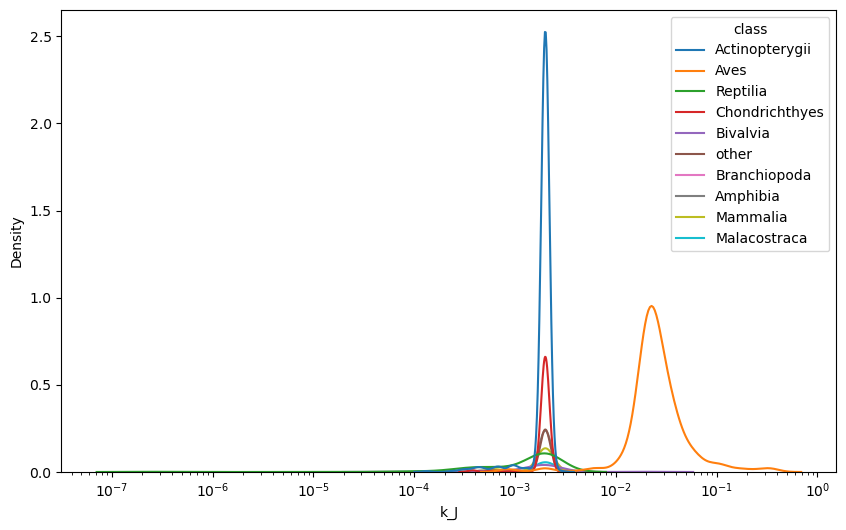

In [35]:
fig, ax = plt.subplots(figsize=(10, 6))
sns.kdeplot(data=all_dfs[dataset_name]['train'], x='k_J', log_scale=True, hue=hue_series['class'], ax=ax) 

In [46]:
all_dfs[dataset_name]['train'].loc[all_dfs[dataset_name]['train']['k_J'] != 0.002]['class'].value_counts()

class
Aves              789
Actinopterygii      6
Mammalia            5
Chondrichthyes      4
Bivalvia            2
Reptilia            1
Name: count, dtype: int64

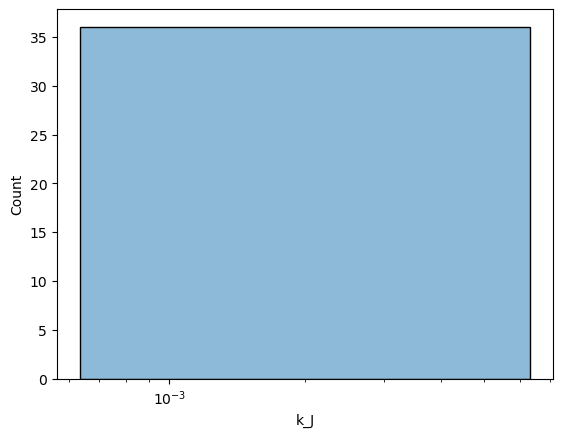

In [31]:
dataset_name = 'biologist_no_pub_age'
aves_train_df = all_dfs[dataset_name]['train'].loc[all_dfs[dataset_name]['train']['class'] == 'Aves']
branchiopoda_train_df = all_dfs[dataset_name]['train'].loc[all_dfs[dataset_name]['train']['class'] == 'Branchiopoda']
ax = sns.histplot(data=branchiopoda_train_df, x='k_J', kde=True, log_scale=True) 

KeyboardInterrupt: 

# Save parameter predictions

### AmP values

In [7]:
dataset_name = 'biologist_no_pub_age'
results_folder = f'../results/{dataset_name}'
dfs = all_dfs[dataset_name]
col_types = all_col_types[dataset_name]
gt_df = pd.concat({ds: dfs[ds][col_types['output']['all']] for ds in ('train', 'test')}).reset_index(level=0, names='data_split')
gt_pars_df = get_core_parameter_predictions(dfs, gt_df)
gt_pars_df.to_csv(f'{results_folder}/parameter_predictions/AmP_predictions.csv', float_format='%.6e')
gt_pars_df

,data_split,z,p_M,kap,v,E_G,h_a,E_Hb,E_Hx,E_Hj,E_Hp,k_J
species,,,,,,,,,,,,
Cyanocorax_beecheii,train,3.012001,532.6248,0.96241,0.041358,7322.803,2.845000e-12,733.700000,6967.000000,733.70000,19490.000,0.021752
Daphnia_longispina,train,0.054706,5686.8260,0.55680,0.020455,4440.588,8.603000e-05,0.017460,0.017460,0.01746,1.401,0.002000
Leptopogon_amaurocephalus,train,1.197300,943.2321,0.91457,0.026841,7320.054,4.218000e-12,291.100000,2017.000000,291.10000,3528.000,0.039250
Myiobius_atricaudus,train,1.259400,421.7193,0.91789,0.022195,7323.597,5.540000e-13,402.600000,1866.000000,402.60000,3719.000,0.017324
Setophaga_citrina,train,1.100100,1290.0970,0.89262,0.035362,7308.211,6.164000e-12,469.500000,1547.000000,469.50000,3069.000,0.052342
...,...,...,...,...,...,...,...,...,...,...,...,...
Platax_orbicularis,test,4.331600,18.6340,0.99911,0.351770,5229.204,6.070000e-11,0.005546,0.005546,0.51260,1557.000,0.002000
Vermivora_cyanoptera,test,1.268100,609.5563,0.93685,0.038686,7326.159,5.322000e-12,314.200000,1059.000000,314.20000,2330.000,0.025146
Aythya_valisineria,test,3.766700,506.8109,0.47999,0.029193,7347.584,4.841000e-14,31990.000000,771800.000000,31990.00000,1396000.000,0.020209


### ML models

In [10]:
def save_parameter_predictions(model_type):
    model = best_models[model_type]
    dataset_name = dataset_of_model[model_type]
    dfs = all_dfs[dataset_name]
    data = all_data[dataset_name]
    col_types = all_col_types[dataset_name]
    pred_df = pd.DataFrame()
    for split in ('train', 'test'):
        if model_type == 'TaxonomicKNNRegressor' and split == 'train':
            train_distance_matrix = model.regressor_._compute_distance_matrix(model.regressor_.train_data, model.regressor_.train_data, data_split='train')
            y_pred = model.regressor_.get_predictions_from_distance_matrix(train_distance_matrix)
        else:
            y_pred = model.predict(data[split]['input'])
        split_pred_df = pd.DataFrame(data=y_pred, index=dfs[split].index, columns=col_types['output']['all'])
        split_pred_df['data_split'] = split
        pred_df = pd.concat([pred_df, split_pred_df])
    pars_df = get_core_parameter_predictions(dfs, pred_df)
    results_folder = f'../results/{dataset_name}'
    predictions_file_name = f'{results_folder}/parameter_predictions/{model_type}_predictions.csv'
    pars_df.to_csv(predictions_file_name, float_format='%.10e')
    print(f'Saved predictions for model {model_type} in {predictions_file_name}')

    return pars_df

In [12]:
for model_type in best_models:
    save_parameter_predictions(model_type)

Saved predictions for model MultiTaskElasticNet in ../results/ratio_output_no_pub_age_taxonomy_ecocodes/parameter_predictions/MultiTaskElasticNet_predictions.csv
Saved predictions for model RandomForestRegressor in ../results/ratio_output_no_pub_age_taxonomy_ecocodes/parameter_predictions/RandomForestRegressor_predictions.csv
Saved predictions for model TaxonomicKNNRegressor in ../results/biologist_no_pub_age/parameter_predictions/TaxonomicKNNRegressor_predictions.csv
Saved predictions for model DEBNetHC in ../results/all_constraints_no_pub_age_taxonomy_ecocodes/parameter_predictions/DEBNetHC_predictions.csv
Saved predictions for model DEBNetSC in ../results/all_constraints_no_pub_age_taxonomy_ecocodes/parameter_predictions/DEBNetSC_predictions.csv


## Finding the bug in feasibility for TaxonomicKNNRegressor

In [12]:
model_type = 'TaxonomicKNNRegressor'
model = best_models[model_type]
dataset_name = dataset_of_model[model_type]
dfs = all_dfs[dataset_name]
data = all_data[dataset_name]
col_types = all_col_types[dataset_name]
model.predict(data['test']['input'][:5])

array([[8.572907e+01, 9.666700e-01, 2.108200e-02, 3.108350e+01,
        5.214539e+03, 5.557000e-09, 5.992000e-03, 5.992000e-03,
        2.903000e-01, 3.222000e+04, 2.000000e-03],
       [1.332003e+02, 8.467800e-01, 1.138800e-01, 1.900060e+01,
        7.843624e+03, 4.067000e-11, 6.149000e+03, 6.149000e+03,
        6.149000e+03, 5.066000e+05, 7.646500e-04],
       [1.144941e+03, 9.645500e-01, 1.607600e-02, 8.833411e+02,
        7.318905e+03, 8.280000e-12, 6.545000e+01, 3.706000e+02,
        6.545000e+01, 1.079000e+03, 3.648500e-02],
       [1.255729e+03, 9.723600e-01, 4.854400e-02, 6.009549e+02,
        7.286974e+03, 1.066000e-13, 2.056000e+02, 1.712000e+03,
        2.056000e+02, 4.478000e+03, 2.596800e-02],
       [4.431604e+03, 8.465000e-01, 2.034200e-02, 5.056958e+02,
        7.283023e+03, 1.262000e-13, 5.032000e+04, 8.076000e+05,
        5.032000e+04, 1.563000e+06, 2.331900e-02]])

In [ ]:
model_type = 'TaxonomicKNNRegressor'
model = best_models[model_type]
dataset_name = dataset_of_model[model_type]
dfs = all_dfs[dataset_name]
data = all_data[dataset_name]
col_types = all_col_types[dataset_name]
results_folder = f'../results/{dataset_name}'
pars_df = pd.read_csv(f'{results_folder}/parameter_predictions/{model_type}_predictions.csv', index_col=0)
pars_df

In [ ]:
species = 'Callorhinus_ursinus'
pars_df.loc[species]

In [ ]:
dfs['test'][col_types['output']['all']].loc[species]

## Finding the bug in feasibility for DEBNets

In [ ]:
model_type = 'DEBNetHC'
model = best_models[model_type]
dataset_name = dataset_of_model[model_type]
dfs = all_dfs[dataset_name]
data = all_data[dataset_name]
col_types = all_col_types[dataset_name]
model_pred_df = pd.DataFrame()
pars_pred_df = pd.DataFrame()
pars_target_df = pd.DataFrame()
for split in ('train', 'test'):
    # Get output of model
    y_pred = model.predict(data[split]['input'])
    split_model_pred_df = pd.DataFrame(data=y_pred, index=dfs[split].index, columns=col_types['output']['all'])
    split_model_pred_df['data_split'] = split
    model_pred_df = pd.concat([model_pred_df, split_model_pred_df])
    # Convert model output to core parameters
    split_pars_pred_df = get_core_parameter_predictions(dfs, split_model_pred_df)
    pars_pred_df = pd.concat([pars_pred_df, split_pars_pred_df])
    
    # Get targets in model scale
    split_model_target_df = dfs[split][col_types['output']['all']].copy()
    split_model_target_df['data_split'] = split
    split_pars_target_df = get_core_parameter_predictions(dfs, split_model_target_df) 
    pars_target_df = pd.concat([pars_target_df, split_pars_target_df])



In [ ]:
model_pred_df.hist()

In [ ]:
all_dfs['all_constraints_no_pub_age_taxonomy_ecocodes']['train'][col_types['output']['all']]

In [ ]:
pars_target_df.loc[species]

In [ ]:
0.8 ** 3

In [ ]:
species = 'Scophthalmus_maximus'
k_J = 0.002
z = pars_pred_df.loc[species, 'z']
p_M = pars_pred_df.loc[species, 'p_M']
E_Hp = pars_pred_df.loc[species, 'E_Hp']
kap = pars_pred_df.loc[species, 'kap']
s_p = model_pred_df.loc[species, 's_p']
p_Am = z * p_M / kap
k_J * E_Hp * (p_M ** 2) / (kap ** 2) / (1-kap) / (p_Am ** 3)

In [ ]:
pars_pred_df.loc[species]

In [ ]:
(0-10)/10

# Compare parameter predictions

Table with the MAPE for each parameter in each line

In [ ]:
def get_mape(model_type, data_split):
    model = best_models[model_type]
    dataset_name = dataset_of_model[model_type]
    dfs = all_dfs[dataset_name]
    data = all_data[dataset_name]
    col_types = all_col_types[dataset_name]
    pred_df = pd.DataFrame()
    
    y_true_ps = data[data_split]['output']
    if 'DEBNet' in model_type:
        y_pred_ps = model.predict(torch.tensor(data[data_split]['input'], dtype=torch.float32))
    elif model_type == 'TaxonomicKNNRegressor' and data_split == 'train':
        train_distance_matrix = model.regressor_._compute_distance_matrix(model.regressor_.train_data, model.regressor_.train_data, model.regressor_.train_weights,
                                                          model.regressor_.train_weights, data_split='train')
        y_pred_ps = model.regressor_.get_predictions_from_distance_matrix(train_distance_matrix)
    else:
        y_pred_ps = model.predict(data[data_split]['input'])
            
    return compute_parameter_mape(y_true=y_true_ps, y_pred=y_pred_ps, output_col_names=col_types['output']['all'])  


In [ ]:
model_list = ['DEBNetHCSoftplus', 'DEBNet', 'DEBNetSC', 'TaxonomicKNNRegressor']
mape_df = pd.DataFrame(index=model_list, columns=PARAMETER_COLS)
for model_type in model_list:
    model_mape = get_mape(model_type=model_type, data_split='test')
    mape_df.loc[model_type] = model_mape['mean_absolute_percentage_error']
mape_df

In [ ]:
model_labels = {
    'DEBNet': 'DEBNet',
    'DEBNetHCSoftplus': 'DEBNet + HC',
    'DEBNetSC': 'DEBNet + SC',
    'TaxonomicKNNRegressor': 'Taxonomic 1-NN',
    
}

In [ ]:
#for mt, row in mape_df.iterrows():
for mt, label in model_labels.items():
    row = mape_df.loc[mt]
    line = f"{label} "
    for par in PARAMETER_COLS:
        mape = row[par]
        if mape == min(mape_df[par]):
            line += f' & \\textbf{{ {mape:.4f} }}'
        else:
            line += f' & {mape:.4f}'
    line += ' \\\\'
    print(line)